
The analytical plasma dispersion solution
=========================================


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline

import astropy.units as u

import matplotlib.pyplot as plt

import numpy as np

from matplotlib import colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

from plasmapy.formulary import parameters as pfp

from plasmapy.dispersion.two_fluid_dispersion import two_fluid_dispersion_solution

In [6]:
help(plasmapy.dispersion.two_fluid_dispersion_solution)

Take a look at the docs to docs to two_fluid_dispersion_solution() for more information

Below we define the required parameters to compute the frequency

In [8]:
k = np.linspace(10**-7, 10**-2, 10000) * u.m ** -1
theta = 45 * u.deg
n = 5 * u.cm ** -3
B = 8.3E-9 * u.T
T_e = 1.6e6 * u.K
T_i = 4.e5 * u.K
z = 1
c = 3.e8 * u.m/u.s
ion = "p+"

# we compute a few other parameters using functions inside the plasmapy.formulary.parameter for scaling the other derived parameters
c_s = pfp.ion_sound_speed(T_e=T_e, T_i=T_i, ion=ion, n_e=z * n) #Sound speed
v_A = pfp.Alfven_speed( B, n, ion=ion) # Alfven speed
omega_ci = pfp.gyrofrequency(B=B, particle=ion, signed=False, Z=z) #Proton Gyrofrequency

# Solve the dispersion equation for the aforememntioned parameters
omega = two_fluid_dispersion_solution(n=n, B=B, T_e=T_e, T_i=T_i, theta=theta, z=z, k=k)


Let's look at the output of the function

In [9]:
omega


{'fast_mode': <Quantity [[1.63839686e-02],
            [1.80262545e-01],
            [3.44262523e-01],
            ...,
            [1.52032015e+03],
            [1.52047209e+03],
            [1.52062404e+03]] rad / s>,
 'alfven_mode': <Quantity [[5.72521434e-03],
            [6.47285265e-02],
            [1.29001438e-01],
            ...,
            [1.02876557e+03],
            [1.02876602e+03],
            [1.02876647e+03]] rad / s>,
 'acoustic_mode': <Quantity [[0.00530912],
            [0.0568217 ],
            [0.10387432],
            ...,
            [0.5618734 ],
            [0.5618734 ],
            [0.5618734 ]] rad / s>}

As expected, the output is a dictionary which has three different modes (fast, alfvenic and acoustic) as its keys and the corresponding data as the value of $\omega$ in _rad/sec_

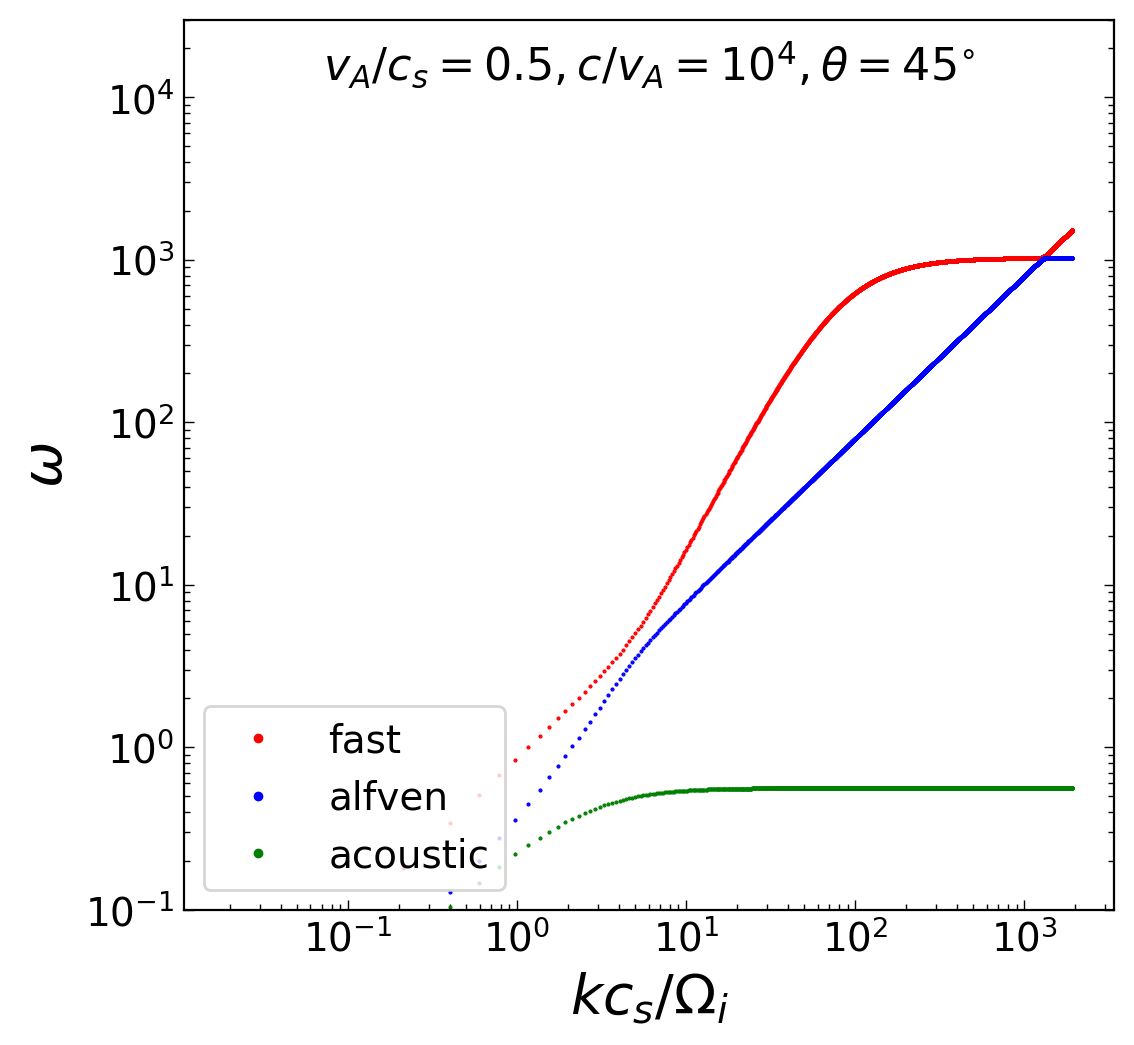

In [11]:
omega_fast     = omega['fast_mode']
omega_alfven   = omega['alfven_mode']
omega_acoustic = omega['acoustic_mode']

# It usually makes more sense to scale wave number with inertial length, thus:
k_prime = k * c_s/omega_ci

fig = plt.figure(
    num=None, figsize=(5, 5), dpi=200, facecolor='w', edgecolor='gray'
)
fig.subplots_adjust(
    left=0.05, right=0.98, top=0.94, bottom=0.05, wspace=0., hspace=0.
)

axs = fig.add_subplot( 1, 1, 1 )
axs.plot(k_prime, omega_fast, 'r.', ms=1, label='fast')
axs.plot(k_prime, omega_alfven, 'b.', ms=1, label='alfven')
axs.plot(k_prime, omega_acoustic, 'g.', ms=1, label='acoustic')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylim(1.e-1, 3.e4)
text = f"$v_A/c_s = {v_A/c_s:.1f}, c/v_A = 10^{np.log10(c/v_A):.0f}, \\theta = {theta.value:.0f}" + "^{\\circ}$"
axs.text(
    0.5,0.95, text, horizontalalignment='center', verticalalignment='center',
    transform=axs.transAxes, fontsize=16
)
axs.set_xlabel(r'$kc_s/\Omega_i$', fontsize=20)
axs.set_ylabel(r'$\omega$', fontsize=20)

axs.get_xaxis().set_tick_params( which='both', direction='in',
labelbottom=True, bottom=True, width=.5, labelsize=14, 
labelrotation=0 )

axs.get_yaxis().set_tick_params(
    which='both', direction='in', labelbottom=True, bottom=True, labelleft=True,
    left=True, labelright=False, right=True, width=.5, labelsize=14,
    labelrotation=0
)

axs.legend(loc=3, markerscale=5, fontsize=14);


Let us now look at the distribution of $\omega$ on a k-$\theta$ plane, where $\theta$ is the direction of propagation

In [12]:
k = np.linspace(10**-7, 10**-2, 10000) * u.m ** -1
theta = np.linspace(5, 85, 100) * u.deg
n = 5 * u.cm ** -3
B = 8.3E-9 * u.T
T_e = 1.6e6 * u.K
T_i = 4.e5 * u.K
z = 1
c = 3.e8 * u.m/u.s
ion = "p+"
# we compute a few other parameters using functions inside the plasmapy.formulary.parameter for scaling the other derived parameters
c_s = pfp.ion_sound_speed(T_e=T_e, T_i=T_i, ion=ion, n_e=z * n) #Sound speed
v_A = pfp.Alfven_speed( B, n, ion=ion) # Alfven speed
omega_ci = pfp.gyrofrequency(B=B, particle=ion, signed=False, Z=z) #Proton Gyrofrequency

# Solve the dispersion equation for the aforememntioned parameters
omega = two_fluid_dispersion_solution(n=n, B=B, T_e=T_e, T_i=T_i, theta=theta, z=z, k=k)


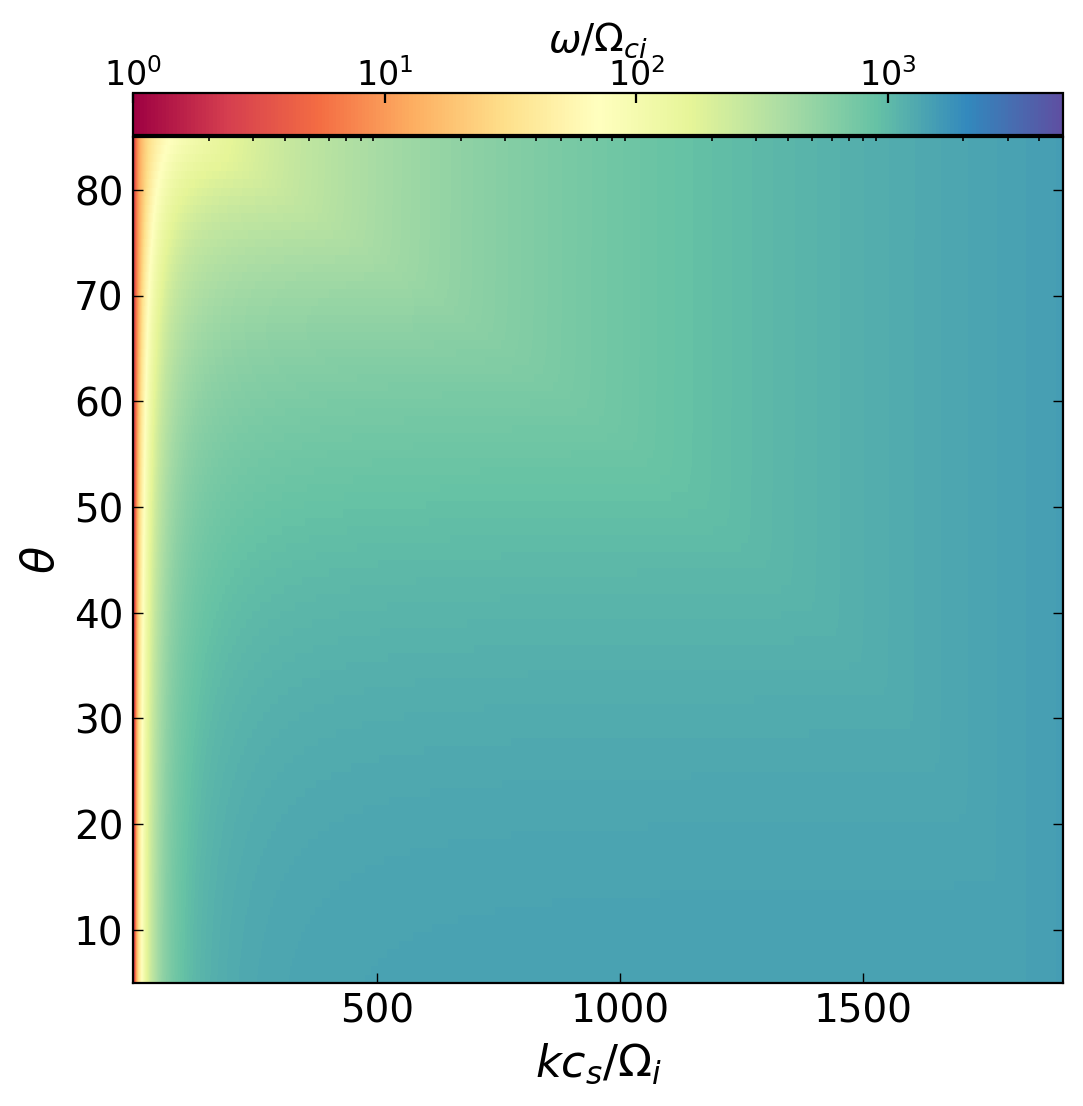

In [16]:
omega_fast     = omega['fast_mode'].value
omega_alfven   = omega['alfven_mode'].value
omega_acoustic = omega['acoustic_mode'].value

k_prime = k * c_s/omega_ci

fig = plt.figure(
    num=None, figsize=(5, 5), dpi=200, facecolor='w', edgecolor='gray'
)
fig.subplots_adjust(
    left=0.05, right=0.98, top=0.94, bottom=0.05, wspace=0., hspace=0.
)

axs = fig.add_subplot(1, 1, 1)
im = axs.imshow(
    np.transpose(omega_fast), aspect='auto', origin='lower',
    extent=[
    np.min(k_prime.value),
    np.max(k_prime.value),
    np.min(theta.value),
    np.max(theta.value)
    ],
    interpolation=None, cmap=plt.cm.Spectral, norm=colors.LogNorm(
    vmin=1.e0, vmax=5.e3
    )
)

axs.set_xscale('linear')
axs.set_xlabel(r'$kc_s/\Omega_i$', fontsize=16)
axs.set_ylabel(r'$\theta$', fontsize=16)

axs.get_xaxis().set_tick_params(
    which='both', direction='in', labelbottom=True, bottom=True, width=.5,
    labelsize=14, labelrotation=0
)

axs.get_yaxis().set_tick_params(
    which='both', direction='in', labelbottom=True, bottom=True, left=True,
    right=True, width=.5, labelsize=14, labelrotation=0
)

divider = make_axes_locatable(axs)
cax = divider.append_axes("top", size="5%", pad=0.01)
cbar = plt.colorbar(
    im, cax=cax, orientation='horizontal', ticks=None, fraction=0.05, pad=0.0
)
cbar.ax.tick_params(
    axis='x', direction='in', pad=0.0, labeltop=True, labelbottom=False,
    color='k', top=True, bottom=False, labelsize=12
)
cbar.ax.xaxis.set_label_position('top')

cbar.set_label(r'$\omega/\Omega_{ci}$', fontsize=14, labelpad=2.50);
